# Transformer une classe de collège en calculateur parallèle pour résoudre l'équation de la chaleur en deux dimensions

- [Version HTML](https://boileau.pages.math.unistra.fr/chaleur2d)
- [Source GitLab](https://gitlab.math.unistra.fr/boileau/chaleur2d)


## Description de l'activité

L'idée est d'appliquer un algorithme itératif sur un domaine à deux dimensions où chaque élève représente à la fois :

- une unité de calcul
- un point de discrétisation de l'espace

Dans un premier temps, pour ne pas les affoler, on ne dévoile pas aux élèves le problème qu'ils s'apprêtent à résoudre.

Chaque élève est positionné sur une grille régulière de 5 lignes et 5 colonnes et se voit attribuer la valeur initiale $0$.
L'algorithme consiste à calculer la valeur de l'itération suivante $n+1$ en faisant la moyenne des valeurs à l'itération $n$ des 4 voisins qui l'entourent : 

$$u^{n+1} = \frac{u_N^{n} + u_S^{n} + u_E^{n} + u_O^{n}}{4}$$.

où $N, S, E$ et $O$ désignent respectivement les voisins Nord, Sud, Est et Ouest sur la grille.

À chaque itération, l'élève écrit sur 4 papiers volants (ou post-it):

1. le numéro de l'itération
2. sa valeur courante

et passe les papiers à ses 4 voisins.  
De son côté, il note les 4 valeurs des papiers qu'il a reçu et en fait la moyenne.

Cas particulier des élèves en bord de grille : dans la direction où l'élève n'a pas de voisin, il reçoit la valeur $1$ (la condition aux limites).

## Mise en oeuvre

1. On distribue à chaque élève :

    - les deux premières pages du document [chaleur2d.pdf](files/chaleur2d.pdf),
    - un paquet de 25 post-it

2. On donne les consignes de préparation
3. On explique le déroulement d'une itération
4. On lance la boucle itérative !

Note : 

- on demande aux élèves de ne garder que 4 chiffres après la virgule
- il est peu probable que la classe soit composée uniquement de 25 élèves. On demande aux élèves sur-numéraires (hors-grille) de vérifier de se déplacer dans la salle au fur et à mesure des itérations pour vérifier les symétries.

**Deux clichés de la mise en oeuvre pratique**

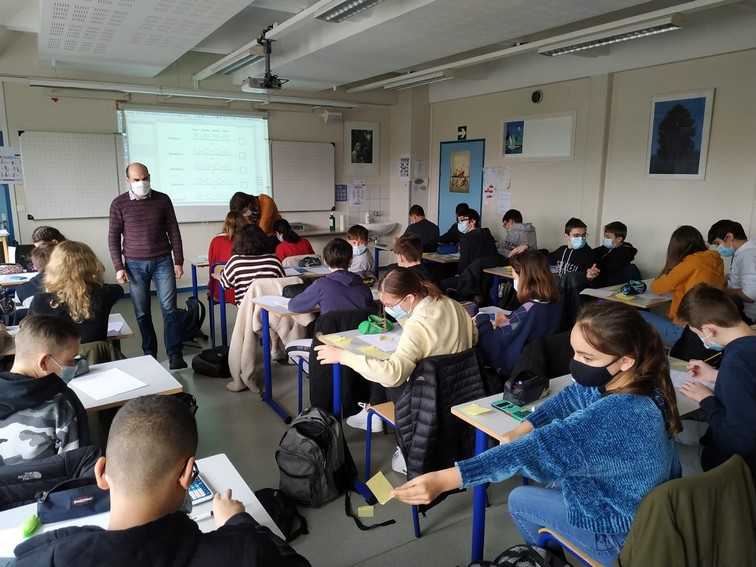
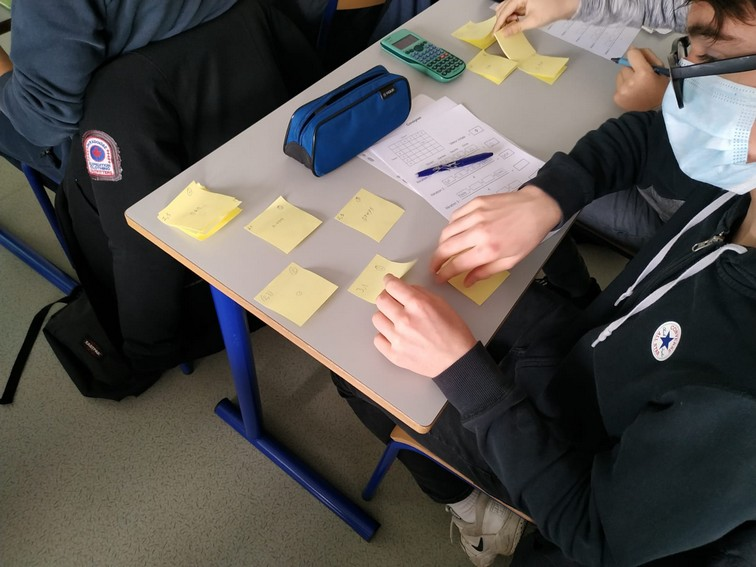

## Un peu de maths et de programmation

### La cuisson du brownie

Pour faire comprendre le type de problème que l'on vient de traiter, on demande aux élèves d'imaginer que la grille représente un brownie carré dont chacun d'entre eux constitue une part.
La préparation du brownie à la température de la pièce (valeur $0$) est plongée avec son moule à l'instant $0$ (c.-à-d. l'itération $0$) dans un four à $200^\circ C$ (valeur $1$).

En réalité, il s'agirait d'un brownie homogène car la conductivité thermique est constante et infiniment épais car le problème est 2D.


### Mise en équation

L'équation de diffusion de la chaleur à coefficient constant $\alpha$ décrit l'évolution de la température $T(x, y, t)$ à la position $(x, y)$ et à l'instant $t$ :

$$\frac{\partial T}{\partial t} - \alpha \Delta{T} = 0$$

où $\Delta$ est l'opérateur Laplacien.

On se propose de discrétiser l'espace et le temps de la façon suivante :

$$
\left\{
    \begin{array}{ll}
        x_i = i \Delta x, \quad \textrm{avec}  \, i  \in \mathbf{N}, \, 0 \leq i \leq n_x \\
        y_j = j \Delta y, \quad \textrm{avec}  \, j  \in \mathbf{N}, \, 0 \leq j \leq n_y \\
        t_n = n \Delta t, \quad \textrm{avec}  \, t  \in \mathbf{N}, \, 0 \leq t \leq n_t \\
    \end{array}
\right.
$$

où $\Delta x$ et $\Delta y$ sont les pas d'espace, $\Delta t$ est le pas de temps (dans ce cas $\Delta$ ne représente pas le Laplacien mais une variation).

On approche la température $T$ par sa valeur discrète :

$$T_{i, j}^n \approx T(x_i, y_j, t_n)$$

Par différences finies, on écrit une version discrète de l'équation de la chaleur :

$$\frac{T_{i, j}^{n + 1} - T_{i, j}^{n}}{\Delta t} - \alpha \left(\frac{T_{i - 1, j}^n - 2 T_{i, j}^n + T_{i + 1, j}^n  }{\Delta x^2} + \frac{T_{i, j - 1}^n - 2 T_{i, j}^n + T_{i, j + 1}^n  }{\Delta y^2} \right) \approx 0$$

Pour simplifier, on prend $\Delta x = \Delta y$ et on réarrange :

$$T_{i, j}^{n + 1} = \alpha \frac{\Delta t}{\Delta x^2} \left(T_{i-1, j}^n + T_{i+1, j}^n + T_{i, j-1}^n + T_{i, j+1}^n- 4 T_{i, j}^n \right) + T_{i, j}^n$$

La condition de stabilité impose :

$$\Delta t \leq \frac{\Delta x^2}{4 \alpha}$$

Si on prend $\Delta t = \frac{\Delta x^2}{4\alpha} = 1$, la relation de récurrence pour $T_{i, j}^n$ s'écrit simplement :

$$T_{i, j}^{n + 1} = \frac{1}{4} \left(T_{i-1, j}^n + T_{i+1, j}^n + T_{i, j-1}^n + T_{i, j+1}^n \right)$$

Autrement dit, on calcule la valeur de la température du point $(i, j)$ à l'instant $n + 1$ en prenant la moyenne de la température de ses 4 voisins directs à l'instant $n$.

### Résolution avec numpy

La programmation de l'algorithme avec Numpy est très simple.

On se propose de faire le calcul sur un domaine carré de $64$ points de côté sur $n_{max} = 500$ itérations temporelles.

In [ ]:
import numpy as np

nx = ny = 64
nmax = 500

La condition initiale est $T(x, y, t = 0) = 0$.

In [ ]:
T = np.zeros((nx + 2, ny + 2))

À l'instant $t = 0$, on impose $T(t \ge 0) = 1$ sur les bords du domaine.

In [ ]:
T[-1, :] = 1.  # haut
T[:, 0] = 1.   # gauche
T[0, :] = 1.   # bas
T[:, -1] = 1.  # droit

On boucle sur les instants $n$ en appliquant la relation de récurrence jusqu'à $n = n_{max}$.
La syntaxe de numpy permet d'écrire les boucles imbriqués sur $i$ et $j$ de manière vectorielle.

In [ ]:
print("Computing solution...")
for n in range(nmax):
    T[1:-1, 1:-1] = 0.25 * (
        T[2:, 1:-1] + T[:-2, 1:-1] +
        T[1:-1, 2:] + T[1:-1, :-2]
        )
print("Done.")

On affiche la solution à $t = n_{max}$ au moyen d'une échelle de couleur.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
ax = plt.subplot()
h = ax.imshow(T, cmap=plt.cm.jet, vmin=0., vmax=1.)
cb = fig.colorbar(h, ax=ax)
ax.set_title(f"Température à t = {nmax}")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('scaled');

### Solution numérique pour une grille de $5 \times 5$ points

Le but est de vérifier le calcul effectué en parallèle par les 25 élèves de la classe (un élève par point de grille).
On calcule donc une grille $5 \times 5$ (plus les points de bords).

Pour alléger le notebook, on place le code dans le module python [`heat2d.py`](files/heat2d.py) que l'on importe.

In [ ]:
from heat2d import Heat, Plot
from matplotlib import animation
from IPython.display import HTML

heat = Heat(nx=5, nmax=50)  # Une grille 5x5

On s'intéresse aux résultats numériques de 6 premières itérations.

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:,.4g}'.format

for n in range(7):
    print(f"t = {n}")
    display(pd.DataFrame(heat.u))
    heat.one_step()

On anime le résultat en échelle de couleurs.

In [ ]:
anim = heat.get_animation(grid=True)
display(HTML(anim.to_jshtml()))

Si on veut être plus précis, il faut augmenter la résolution spatiale (et temporelle car $\Delta t = \frac{\Delta x^2}{4\alpha}$ ).
On calcule le même problème sur une grille effective $(125 \times 125)$.

In [ ]:
heat = Heat(nx=125, nmax=15000)
anim = heat.get_animation()
display(HTML(anim.to_jshtml()))

### Comparaison avec la solution théorique

On calcule la solution analytique de l'évolution de la température au centre du domaine $(x, y) = (0.5, 0.5)$ (d'après [*The heat and wave equations in 2D and 3D*](https://ia803002.us.archive.org/28/items/flooved1678/flooved1678.pdf), Matthew J. Hancock, 2006).

In [ ]:
def u_m_n(m, n, t):
    return 16 / (m * n * np.pi**2) * np.sin(m*np.pi/2) * np.sin(n*np.pi/2) \
              * np.exp(- np.pi**2 * (m**2 + n**2) * t)
    
def analytical_T(t, nmax=100):
    # La solution est une double somme infinie
    # donc l'entier nmax doit être pris le plus grand possible
    sum_m_n = 0
    for m in range(1, nmax, 2):
        for n in range(1, nmax, 2):
            sum_m_n += u_m_n(m, n, t)
    return sum_m_n

On calcule la solution numérique pour différentes résolutions.

In [ ]:
%matplotlib inline
import numpy as np

# La classe
heat5 = Heat(nx=5, nmax=45)

# Tout le collège
heat25 = Heat(nx=25, nmax=700)

# Une université !
heat125 = Heat(nx=125, nmax=15000)

On compare à la solution analytique.
Pour une illustration plus parlante, on opère un changement d'échelle : le problème entre $0$ et $1$ est converti en un problème entre $20^{\circ}C$ (température ambiante) et $200^{\circ}C$ (température du four).

In [ ]:
def plot_center(fig, ax, heat, *args, **kwargs):
    ax.set_title("Température du centre en fonction du temps")
    ax.set_xlabel("t [min]")
    ax.set_ylabel("T [°C]")
    
    # Echelle de temps normalisée par le pas de temps
    t = np.linspace(0, 120 *(heat.nmax + 1) / ((heat.nx + 2)**2) / 4., heat.nmax + 1) 
    ax.plot(t, 20 + 180 * heat.get_center(), label=f"{heat.nx} x {heat.ny}", **kwargs)

fig, ax = plt.subplots(figsize=(8, 6))
plot_center(fig, ax, heat5, marker='o', mfc='none', markersize=10, linestyle='')
plot_center(fig, ax, heat25, marker='o', mfc='none', markersize=8, markevery=15, linestyle='')
plot_center(fig, ax, heat125, marker='o', mfc='none', markersize=6, markevery=300, linestyle='')

t = np.linspace(0, 0.25, 40)  # échelle de temps pour la solution analytique
ax.plot(120 * t, 20 + 180 *(analytical_T(0, nmax=500) - analytical_T(t, nmax=500)),
        label="analytique", color='grey')
ax.legend()
ax.grid()
plt.show()

## Une autre application : flouter une image

On va utiliser le même algorithme pour donner un effet de flou sur une image. Cette fois-ci, ce n'est pas la température qu'on fait évoluer mais la luminosité de chaque pixel entre les valeurs $0$ (le noir) et $1$ (le blanc).

In [ ]:
from PIL import Image
import numpy as np
from ipywidgets import interact, IntSlider, fixed

src = Image.open('college_brant_20210319.jpg')

def floute(src, nmax=0, gris=False):
    if gris:
        src = src.convert('L')
    src.load()
    data = np.asarray(src, dtype="int32")
    for n in range(nmax):
        data[1:-1, 1:-1] = 0.25 * (
            data[2:, 1:-1] + data[:-2, 1:-1] +
            data[1:-1, 2:] + data[1:-1, :-2]
        )
    mode = "L" if gris else "RGB"  # handle color vs grey scale
    img = Image.fromarray(data.astype("uint8"), mode)
    print(f"nmax = {nmax}")
    display(img)
    
interact(floute, nmax=IntSlider(min=0, max=100, step=5, continuous_update=False), src=fixed(src));

## Conclusion

On peut évoquer : 

- L'analogie avec un calculateur parallèle : les unités indépendantes, les échanges de données, la gestion des erreurs, etc.
- La convergence en maillage d'une méthode numérique
- L'approche classique de la simulation numérique : le cas simple (carré) comme validation nécessaire avant de simuler des problèmes sans solution théorique.